In [2]:
import sys
!{sys.executable} -m pip install numpy


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sys
!{sys.executable} -m pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:


import sys
!{sys.executable} -m pip install opencv-python tensorflow


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Cell 1: Environment setup
# Install missing packages in the notebook kernel
%pip install tensorflow
%pip install opencv-python

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print("TensorFlow version:", tf.__version__)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


TensorFlow version: 2.20.0


In [6]:
# Cell 1.2: Download and prepare the dataset
# Install kagglehub in the notebook environment
%pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)




[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\dashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: you may need to restart the kernel to use updated packages.
Path to dataset files: C:\Users\dashi\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [7]:
# Cell 2: Download FER2013 via kagglehub
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

# Expecting structure: <path>/train/<class>/* and <path>/test/<class>/*
train_dir = os.path.join(path, "train")
test_dir  = os.path.join(path, "test")

assert os.path.isdir(train_dir), f"Train dir not found: {train_dir}"
assert os.path.isdir(test_dir),  f"Test dir not found: {test_dir}"

Path to dataset files: C:\Users\dashi\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [8]:
# Cell 3: Data generators (grayscale, 48x48)
img_size = (48, 48)
batch_size = 64

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=12,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.1,
    horizontal_flip=True
)

val_aug = ImageDataGenerator(rescale=1./255)

train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

val_data = val_aug.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_classes = train_data.num_classes
class_indices = train_data.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}
print("Classes:", idx_to_class)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Classes: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


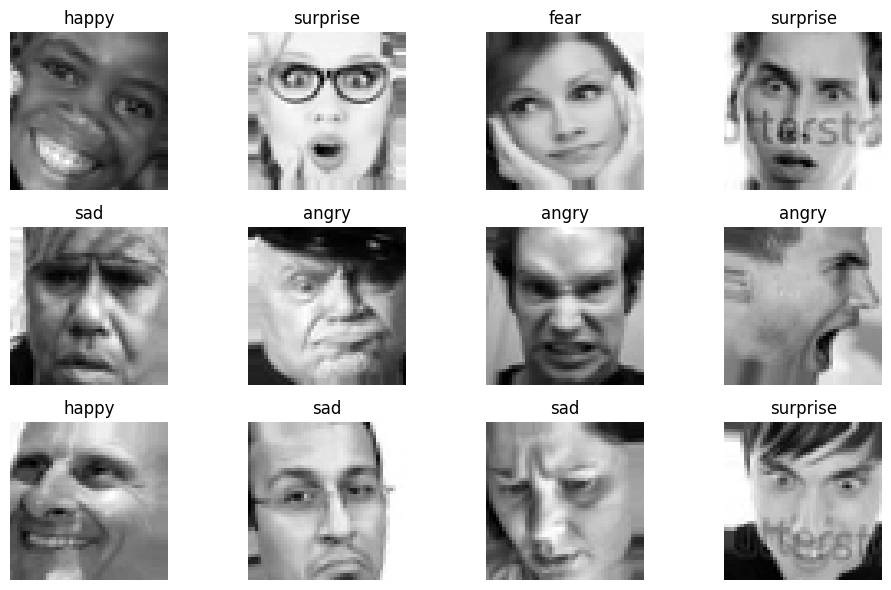

In [9]:
%pip install scipy

# Cell 4: Quick sanity check — visualize a batch
x_batch, y_batch = next(train_data)
plt.figure(figsize=(10, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_batch[i].squeeze(), cmap="gray")
    plt.title(idx_to_class[np.argmax(y_batch[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
# Cell 5: Shivam's compact CNN (balanced for speed and accuracy)
def build_model(input_shape=(48,48,1), num_classes=7):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(num_classes=num_classes)
model.summary()

c:\Users\dashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,447 (5.04 MB)

 Trainable params: 1,320,999 (5.04 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Cell 6: Callbacks for stable training
checkpoint_path = "best_fer_cnn.keras"
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

epochs = 25
history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=callbacks)

Epoch 1/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.2857 - loss: 1.7142

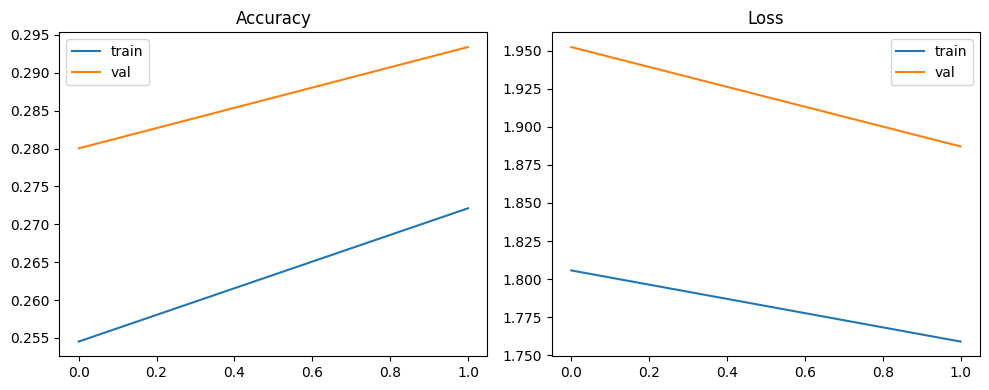

In [14]:
# Cell 7: Training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Cell 8: Evaluate and confusion matrix
# Install missing packages if needed
%pip install scikit-learn
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
              precision    recall  f1-score   support

       angry       0.19      0.01      0.01       958
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.15      0.16      1024
       happy       0.30      0.93      0.46      1774
     neutral       0.29      0.04      0.06      1233
         sad       0.20      0.05      0.08      1247
    surprise       0.55      0.24      0.33       831

    accuracy                           0.29      7178
   macro avg       0.24      0.20      0.16      7178
weighted avg       0.27      0.29      0.20      7178



c:\Users\dashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

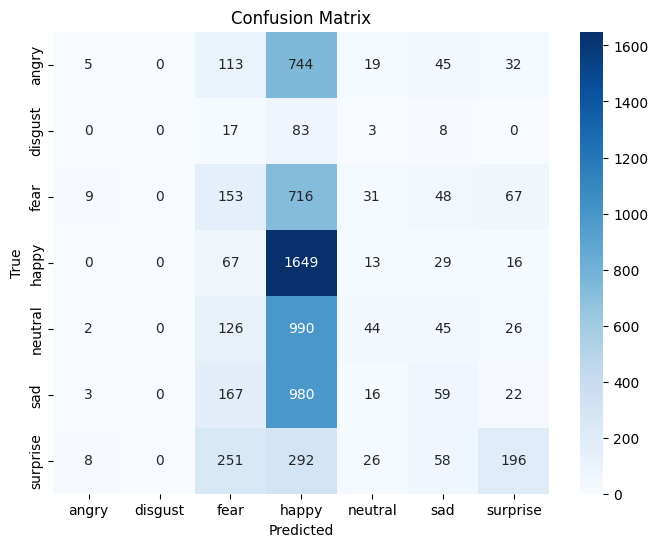

In [16]:


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_preds = model.predict(val_data)
y_true = val_data.classes
y_pred = np.argmax(val_preds, axis=1)

print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(num_classes)]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[idx_to_class[i] for i in range(num_classes)],
            yticklabels=[idx_to_class[i] for i in range(num_classes)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [17]:
# Cell 9: Save final model
final_model_path = "fer_cnn_final.keras"
model.save(final_model_path)
print("Saved model to:", final_model_path)

Saved model to: fer_cnn_final.keras


In [18]:
# Cell 10: Load for inference (optional)
loaded_model = tf.keras.models.load_model(checkpoint_path if os.path.exists(checkpoint_path) else final_model_path)
print("Loaded model ready for inference.")

Loaded model ready for inference.


In [19]:
# Cell 11: Real-time face expression recognition
# Note: Requires a webcam. Press 'q' to quit.
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

emotion_dict = {i: idx_to_class[i].capitalize() for i in range(num_classes)}
print("Emotion labels:", emotion_dict)

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Webcam not accessible. Try a different index (e.g., 1) or check permissions.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, img_size)
        roi = roi_gray.astype("float32") / 255.0
        roi = np.expand_dims(roi, axis=-1)
        roi = np.expand_dims(roi, axis=0)

        preds = loaded_model.predict(roi, verbose=0)
        emotion = emotion_dict[int(np.argmax(preds))]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2.imshow("Face Expression Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Emotion labels: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
